In [1]:
from sample import sample_generator
from estimators import ClusteredSegmentation
from BarcodeScanner import cluster_barcode_scanner
import pandas as pd
import numpy as np
from sklearn.metrics import auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [3]:
rng = sample_generator(4, 2000)

In [10]:
cluster = ClusteredSegmentation(n_clusters = 8)
cluster.fit(rng.barcode.reshape(-1,1), rng.y)
cluster.tau_metric, cluster.tau_metric.tau_est

(tau(n=2000, p=16, q=8, r_sqf=0.8520629463574996, r_sqr=0.8510905124258084, alpha=0.05),
 0.006573295247863792)

In [14]:
scanner = cluster_barcode_scanner(rng, cluster)

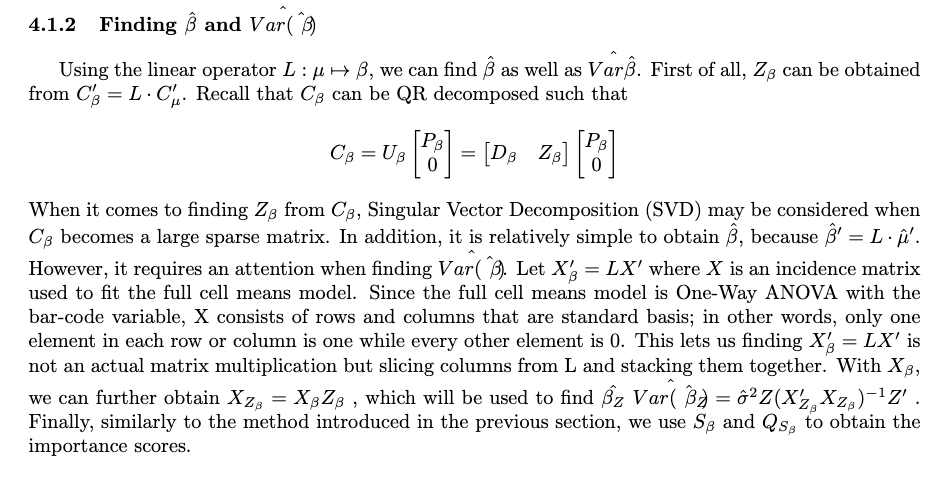

#### Step 1. Finding $\hat{\beta}$

In [15]:
cluster.full_to_reduced_with_counts

,full,y,reduced,counts
0,0,-5.646861,2,58
1,1,-9.174613,1,110
2,2,-1.571653,5,196
3,3,-2.100923,4,358
4,4,0.956511,6,19
5,5,-10.885291,0,38
6,6,-1.483242,5,53
7,7,-3.320966,3,109
8,8,2.278078,6,77
9,9,2.588447,6,112


In [23]:
mu_reduced = cluster.predict(np.array(range(16)).reshape(-1,1)).reset_index(drop = True)
beta_hat = rng.L.dot(mu_reduced.T)

In [26]:
C_mu = scanner.C
C_beta = (rng.L.dot(C_mu.T)).T

In [37]:
C_beta.shape

(8, 16)

In [50]:
#finding Z_beta
from scipy.linalg import qr
Z = qr(C_beta.T)[0][:, 8:]

In [51]:
X_beta

NameError: name 'X_beta' is not defined

In [53]:
rng.barcode

array([[ 3],
       [ 2],
       [11],
       ...,
       [11],
       [ 8],
       [15]], dtype=uint8)

In [64]:
X_z = rng.L[:,rng.barcode.reshape(-1)].T.dot(Z)

In [65]:
cluster.MSE

5.034489704470432

In [66]:
from scipy.linalg import inv

In [71]:
var_beta = cluster.MSE * Z.dot(inv(X_z.T.dot(X_z))).dot(Z.T)

#### Example

In [107]:
S.shape

(2047, 16)

In [165]:
S = scanner.all_available_beta_for_test
s = S[30]

In [166]:
s

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [167]:
q = scanner.gen_beta_contrasts(s)

In [168]:
q.shape

(5, 16)

In [169]:
f_value = q.dot(beta_hat).T.dot(inv(q.dot(var_beta).dot(q.T))).dot((q.dot(beta_hat)).T)

In [170]:
f_value

14243.842804987195

In [171]:
from scipy.stats import f
cdf = f.cdf(f_value, s.shape[0], X_z.shape[0]-X_z.shape[1] , loc=0, scale=1)


In [172]:
cdf

0.9999999999999999

In [173]:
rng.interactions

{'X1*X2': -6.369193523719086,
 'X1*X3': -3.3093656182632514,
 'X1*X4': 4.705092995238325,
 'X2*X3': -5.776712266313117,
 'X2*X4': -7.306541030508544,
 'X3*X4': 3.27442514094101,
 'X1*X2*X4': -6.22726636434979,
 'X2*X3*X4': 5.82862924382513,
 'X1*X2*X3*X4': -3.6814424548419984}